# Mean-Reversion
This is a backtest of the following strategy:
Buy Nifty Bees ETF if moving average of price drops below 0.15 percentile

Esentially what we are trying to do is buy the dips of the ETF ,decreasing average holding cost for the same.
This can be used as an investment strategy.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import yfinance as yf
from datetime import date
sb.set()


from matplotlib import rcParams
rcParams['figure.figsize'] = 16,12 #to set figure size

In [2]:
today = str(date.today())

In [3]:
year=int(today[:4])
year-=1
five_years_ago= str(year) + today[4:]
five_years_ago

'2020-10-11'

In [4]:
df = yf.download('NIFTYBEES.NS', 
                  start=five_years_ago, 
                  end=today, 
                  progress=False,
                )
df= df.drop('Open', axis=1)
df= df.drop('High', axis=1)
df= df.drop('Low', axis=1)
df= df.drop('Adj Close', axis=1)
df= df.drop('Volume', axis=1)
df

,Close
Date,
2020-10-12,126.959999
2020-10-13,127.019997
2020-10-14,127.419998
2020-10-15,124.809998
2020-10-16,125.620003
...,...
2021-10-04,191.029999
2021-10-05,192.199997
2021-10-06,190.190002


In [5]:

df['returns'] = df['Close'].diff()
df['dummy'] = df['Close'].shift(1)
df['returns']=(df['returns']/df['dummy'])
df=df.drop('dummy',axis=1)
df

,Close,returns
Date,,
2020-10-12,126.959999,NaN
2020-10-13,127.019997,0.000473
2020-10-14,127.419998,0.003149
2020-10-15,124.809998,-0.020483
2020-10-16,125.620003,0.006490
...,...,...
2021-10-04,191.029999,0.009566
2021-10-05,192.199997,0.006125
2021-10-06,190.190002,-0.010458


In [6]:
df['ma']= df['Close'].rolling(3).mean()
df

,Close,returns,ma
Date,,,
2020-10-12,126.959999,NaN,NaN
2020-10-13,127.019997,0.000473,NaN
2020-10-14,127.419998,0.003149,127.133331
2020-10-15,124.809998,-0.020483,126.416664
2020-10-16,125.620003,0.006490,125.949999
...,...,...,...
2021-10-04,191.029999,0.009566,190.120000
2021-10-05,192.199997,0.006125,190.816666
2021-10-06,190.190002,-0.010458,191.139999


In [7]:
df['ratio']=df['Close']/df['ma']
df

,Close,returns,ma,ratio
Date,,,,
2020-10-12,126.959999,NaN,NaN,NaN
2020-10-13,127.019997,0.000473,NaN,NaN
2020-10-14,127.419998,0.003149,127.133331,1.002255
2020-10-15,124.809998,-0.020483,126.416664,0.987291
2020-10-16,125.620003,0.006490,125.949999,0.997380
...,...,...,...,...
2021-10-04,191.029999,0.009566,190.120000,1.004786
2021-10-05,192.199997,0.006125,190.816666,1.007250
2021-10-06,190.190002,-0.010458,191.139999,0.995030


# Getting required percentiles after testing multiple values and choosing best option

After testing multiple values, the 5th and 80th percentile seemed to capture 
most of the action

In [8]:
x=df.quantile(0.15)
p1=x['ratio'] #15th Percentile


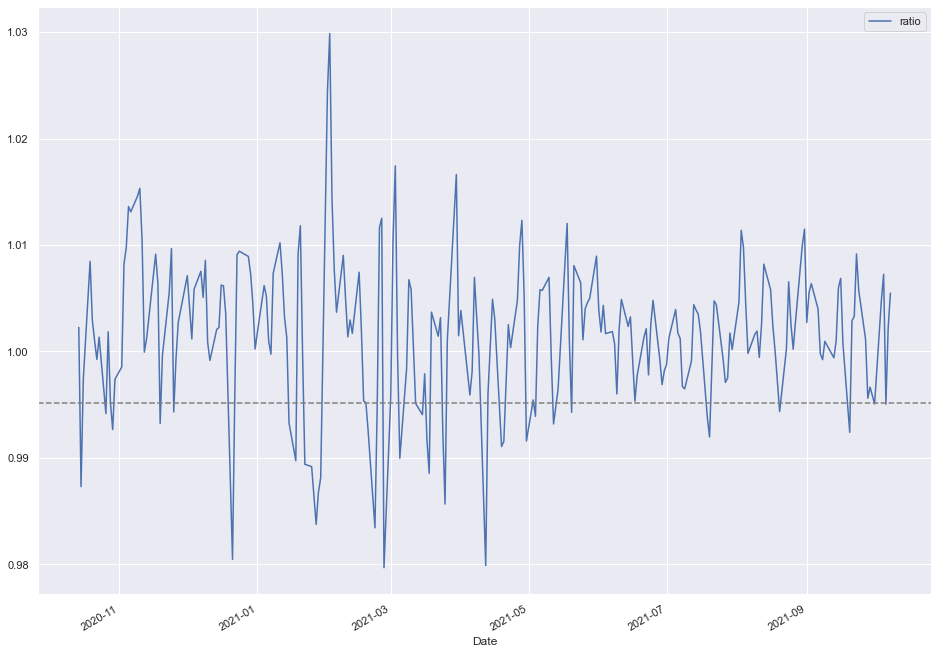

In [9]:
df['ratio'].dropna().plot(legend = True)
plt.axhline(p1, c= (.5,.5,.5), ls='--')

In [10]:
long = p1
df['position'] = np.where(df.ratio < long, 1, 0)
#df['position'] = df['position'].ffill()

In [11]:
df

,Close,returns,ma,ratio,position
Date,,,,,
2020-10-12,126.959999,NaN,NaN,NaN,0
2020-10-13,127.019997,0.000473,NaN,NaN,0
2020-10-14,127.419998,0.003149,127.133331,1.002255,0
2020-10-15,124.809998,-0.020483,126.416664,0.987291,1
2020-10-16,125.620003,0.006490,125.949999,0.997380,0
...,...,...,...,...,...
2021-10-04,191.029999,0.009566,190.120000,1.004786,0
2021-10-05,192.199997,0.006125,190.816666,1.007250,0
2021-10-06,190.190002,-0.010458,191.139999,0.995030,1


In [12]:
Position=df['position']
Close=df['Close']
stock_counter=0
total=0

strat_port_value=[]
loc=0
for i in range(0,len(Position),1):
    if(Position[i]==1):
        loc=i
        break
    else:
        strat_port_value.append(Close[i])
strat_port_value


[126.95999908447266, 127.0199966430664, 127.41999816894531]

In [13]:
for i in range(loc,len(Position),1):
    currentPrice=Close[i]
    if(Position[i]==1):
        total+=currentPrice
        stock_counter+=1
    strat_port_value.append(total/stock_counter)
        
strat_port_value[-1]

155.6181083885399

In [14]:
df['strat_price_value']=strat_port_value
df

,Close,returns,ma,ratio,position,strat_price_value
Date,,,,,,
2020-10-12,126.959999,NaN,NaN,NaN,0,126.959999
2020-10-13,127.019997,0.000473,NaN,NaN,0,127.019997
2020-10-14,127.419998,0.003149,127.133331,1.002255,0,127.419998
2020-10-15,124.809998,-0.020483,126.416664,0.987291,1,124.809998
2020-10-16,125.620003,0.006490,125.949999,0.997380,0,124.809998
...,...,...,...,...,...,...
2021-10-04,191.029999,0.009566,190.120000,1.004786,0,154.657778
2021-10-05,192.199997,0.006125,190.816666,1.007250,0,154.657778
2021-10-06,190.190002,-0.010458,191.139999,0.995030,1,155.618108


In [15]:
df['Buy/Hold-returns']=0
df

,Close,returns,ma,ratio,position,strat_price_value,Buy/Hold-returns
Date,,,,,,,
2020-10-12,126.959999,NaN,NaN,NaN,0,126.959999,0
2020-10-13,127.019997,0.000473,NaN,NaN,0,127.019997,0
2020-10-14,127.419998,0.003149,127.133331,1.002255,0,127.419998,0
2020-10-15,124.809998,-0.020483,126.416664,0.987291,1,124.809998,0
2020-10-16,125.620003,0.006490,125.949999,0.997380,0,124.809998,0
...,...,...,...,...,...,...,...
2021-10-04,191.029999,0.009566,190.120000,1.004786,0,154.657778,0
2021-10-05,192.199997,0.006125,190.816666,1.007250,0,154.657778,0
2021-10-06,190.190002,-0.010458,191.139999,0.995030,1,155.618108,0


In [16]:
df['vs_strat_returns']=(df['Close']-df['strat_price_value'])/df['Close']
df['vs_strat_returns']=df['vs_strat_returns']*100
df

,Close,returns,ma,ratio,position,strat_price_value,Buy/Hold-returns,vs_strat_returns
Date,,,,,,,,
2020-10-12,126.959999,NaN,NaN,NaN,0,126.959999,0,0.000000
2020-10-13,127.019997,0.000473,NaN,NaN,0,127.019997,0,0.000000
2020-10-14,127.419998,0.003149,127.133331,1.002255,0,127.419998,0,0.000000
2020-10-15,124.809998,-0.020483,126.416664,0.987291,1,124.809998,0,0.000000
2020-10-16,125.620003,0.006490,125.949999,0.997380,0,124.809998,0,0.644806
...,...,...,...,...,...,...,...,...
2021-10-04,191.029999,0.009566,190.120000,1.004786,0,154.657778,0,19.040057
2021-10-05,192.199997,0.006125,190.816666,1.007250,0,154.657778,0,19.532893
2021-10-06,190.190002,-0.010458,191.139999,0.995030,1,155.618108,0,18.177556


<AxesSubplot:xlabel='Date'>

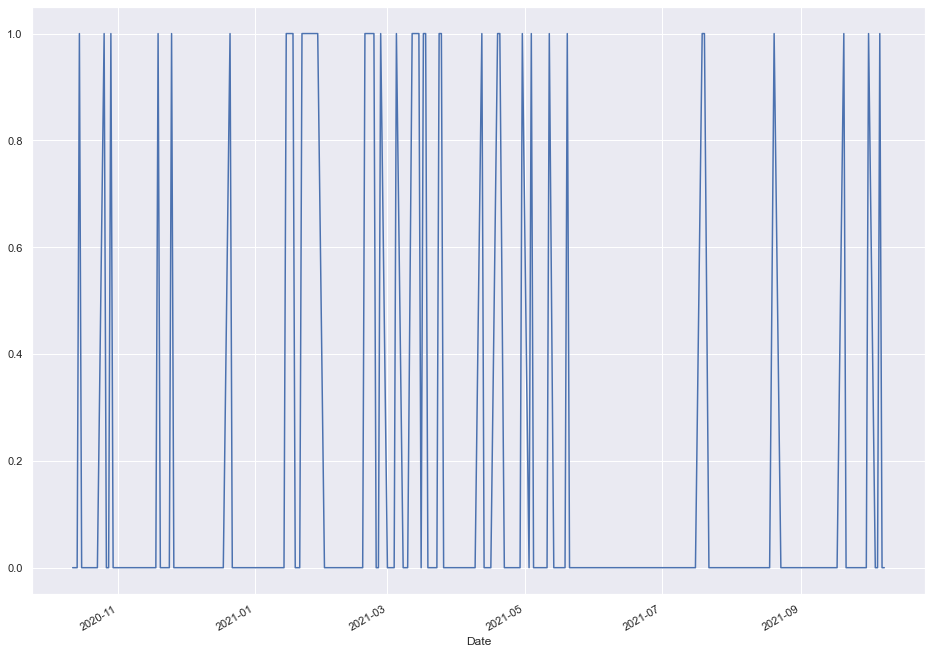

In [17]:
df.position.plot()

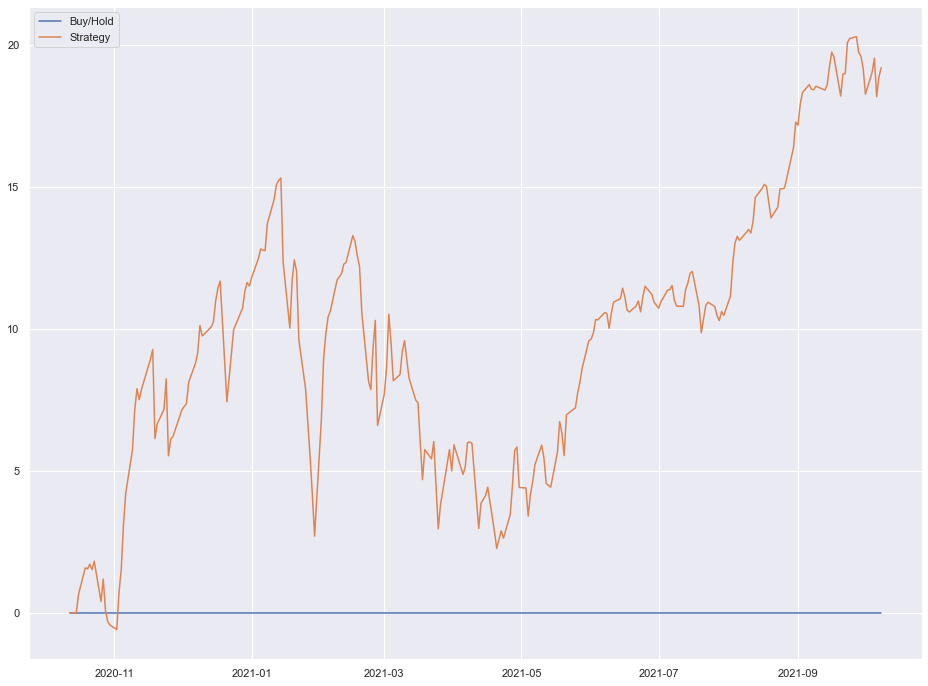

In [18]:
plt.plot(df['Buy/Hold-returns'], label='Buy/Hold')
plt.plot(df['vs_strat_returns'], label='Strategy')
plt.legend();

In [19]:
buyhold_retret=(Close[len(Close)-1]-Close[0]) / Close[0]
print("Buy/Hold return : ", buyhold_retret*100 , "%")


strat_retret= buyhold_retret + abs(buyhold_retret*df['vs_strat_returns'][-1]/100)
print("Strategy return : ", strat_retret*100 , "%")

Buy/Hold return :  51.685572794405786 %
Strategy return :  61.60558845531594 %


The Strategy outperforms the ETF by 10% in a span of 1 year.